In [46]:
%reset
%matplotlib inline
from feature_engineering import *

#regression imports 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

#model selection
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV

# evaluation metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error, make_scorer

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Import data

In [47]:
# Read in data
data = pd.read_csv('./data/data.csv')

# what am I trying to predict 
predict_stations = False

In [48]:
data['day'] = data['date'].apply(lambda x : int(x.split('-')[-1]))
train_df = data[data.day <= 19]
test_df = data[data.day == 20]

In [49]:
del data

In [50]:
if predict_stations == False:
    train_df = train_df.drop(['station', 'total_in'], axis = 1)
    train_df = train_df.groupby(['date', 'time', 'member_type', 
                               'weather_description', 'temp_in_f', 'humidity_in_%', 'pressure',
                               'visibility_in_miles', 'wind_direction', 'wind_speed_in_mph',
                               'temp_in_f_delta', 'pressure_delta', 'humidity_delta',
                               'visibility_delta', 'wind_speed_delta', 'day'], as_index = False)['total_out'].sum()
    
    test_df = test_df.drop(['station', 'total_in'], axis = 1)
    test_df = test_df.groupby(['date', 'time', 'member_type', 
                               'weather_description', 'temp_in_f', 'humidity_in_%', 'pressure',
                               'visibility_in_miles', 'wind_direction', 'wind_speed_in_mph',
                               'temp_in_f_delta', 'pressure_delta', 'humidity_delta',
                               'visibility_delta', 'wind_speed_delta', 'day'], as_index = False)['total_out'].sum()

In [51]:
train_df.columns

Index(['date', 'time', 'member_type', 'weather_description', 'temp_in_f',
       'humidity_in_%', 'pressure', 'visibility_in_miles', 'wind_direction',
       'wind_speed_in_mph', 'temp_in_f_delta', 'pressure_delta',
       'humidity_delta', 'visibility_delta', 'wind_speed_delta', 'day',
       'total_out'],
      dtype='object')

In [52]:
train_df.head()

,date,time,member_type,weather_description,temp_in_f,humidity_in_%,pressure,visibility_in_miles,wind_direction,wind_speed_in_mph,temp_in_f_delta,pressure_delta,humidity_delta,visibility_delta,wind_speed_delta,day,total_out
0,2018-01-01,00:00:00,Casual,Clear,11.0,75.0,30.0,10.0,S,2.7,-49.0,1.0,-7.0,0.0,-8.3,1,6.0
1,2018-01-01,00:00:00,Member,Clear,11.0,75.0,30.0,10.0,S,2.7,-49.0,1.0,-7.0,0.0,-8.3,1,28.0
2,2018-01-01,01:00:00,Casual,Clear,10.0,77.0,30.0,10.0,N,1.0,-1.0,0.0,2.0,0.0,-1.7,1,11.0
3,2018-01-01,01:00:00,Member,Clear,10.0,77.0,30.0,10.0,N,1.0,-1.0,0.0,2.0,0.0,-1.7,1,38.0
4,2018-01-01,02:00:00,Casual,Clear,10.0,72.0,30.0,10.0,N,1.0,0.0,0.0,-5.0,0.0,0.0,1,7.0


In [53]:
train_df.visibility_in_miles.value_counts().values[1:].sum()

2145

## Feature engineering

In [54]:
# do feature engineering 
train_df = holiday(train_df)
train_df = season(train_df)
train_df = date_feature(train_df)
train_df = member_type(train_df)
train_df = weather(train_df)     # i think these two features mighht be making the wjole tjing worse
train_df = wind_direction(train_df)
if predict_stations == True:
    train_df = top_i_station_onehot(train_df, top = 25)
    
    # keep only data for the top stations 
    train_df = train_df[train_df['other'] == 0]
    
train_df = hour_features(train_df)
#train_df = humidity_feature(train_df)
#train_df = visibility_feature(train_df)
train_df = heat_index(train_df)
train_df = wind_chill(train_df)

In [55]:
test_df = holiday(test_df)
test_df = season(test_df)
test_df = date_feature(test_df)
test_df = member_type(test_df)
test_df = weather(test_df)     # i think these two features mighht be making the wjole tjing worse
test_df = wind_direction(test_df)
if predict_stations == True:
    test_df = top_i_station_onehot(test_df, top = 25)
    
    # keep only data for the top stations 
    test_df = test_df[test_df['other'] == 0]
    
test_df = hour_features(test_df)
#test_df = humidity_feature(test_df)
#test_df = visibility_feature(test_df)
test_df = heat_index(test_df)
test_df = wind_chill(test_df)


In [56]:
train_df.columns

Index(['time', 'temp_in_f', 'humidity_in_%', 'pressure', 'visibility_in_miles',
       'wind_speed_in_mph', 'temp_in_f_delta', 'pressure_delta',
       'humidity_delta', 'visibility_delta', 'wind_speed_delta', 'day',
       'total_out', 'holiday', 'month', 'autumn', 'spring', 'summer', 'winter',
       'weekday', 'Casual', 'Member', 'thunderstorm', 'cloudy', 'drizzle',
       'fog', 'haze', 'rain', 'snow', 'clear', 'N', 'E', 'W', 'S', 'day_time',
       'evening_peak', 'morning_peak', 'night_time', 'heat_index',
       'wind_chill'],
      dtype='object')

In [57]:
## need to do something better with this
train_df['time'] =  train_df['time'].apply(lambda x: int(x.split(':')[0]))
## need to do something better with this
test_df['time'] =  test_df['time'].apply(lambda x: int(x.split(':')[0]))

## Models

In [67]:
# Splitting train data into cross validation elements.
# Right now we predict total_in Problem label flow not correct 

if predict_stations == True:
    drop_features = [ 'total_in', 'station', 'total_out', 'pressure_delta', 'pressure', 
                     'visibility_delta', 'Casual', 'sum_ins_outs', 'other']

    models = [RandomForestRegressor(max_depth = 5, n_estimators = 100), AdaBoostRegressor(), 
              BaggingRegressor(), KNeighborsRegressor(), Lasso(alpha = 0.1, max_iter=100)] #SVR() MLPRegressor(random_state=0, activation='relu', hidden_layer_sizes=(2,))
    model_names = ['RandomForest', 'AdaBoost', 'Bagging', 'Kneighnours', 'Lasso'] # SVR 'Neural Network', 


if predict_stations == False:
    drop_features = [ 'total_out', 'day', 'visibility_delta', 'Casual','humidity_in_%', 'pressure', 'visibility_in_miles',
       'wind_speed_in_mph', 'temp_in_f_delta', 'pressure_delta',
       'humidity_delta', 'visibility_delta', 'wind_speed_delta'] 
    models = [RandomForestRegressor(bootstrap=True, max_depth=10, n_estimators=100, random_state=42), 
              AdaBoostRegressor(random_state=42, n_estimators=100, learning_rate= 0.001), 
          BaggingRegressor(), KNeighborsRegressor(n_neighbors=3), 
              GradientBoostingRegressor(n_estimators = 5000, alpha = 0.01), 
             Ridge()] #SVR(), , Lasso(alpha = 0.1, max_iter=100)
    model_names = ['RandomForest', 'AdaBoost', 'Bagging', 'Kneighnours', 'Gradient_boosting', 'Ridge'] # SVR

X_train, X_test, y_train, y_test = train_test_split(train_df.drop(drop_features, axis = 1),
                                                    np.log1p(train_df['total_out']), test_size = 0.10, random_state = 42)

# SVR removed for now cause f**

log_rmse = []
mse = []
r2 = []
mae = []
d = {}
for model in range (len(models)):
    print('Running model: ', model_names[model])
    clf = models[model]
    clf.fit(X_train, y_train)
    print('model fitted..')
    test_pred = clf.predict(X_test)
    print('predictions done..')
    model_log_rmse = np.sqrt(mean_squared_log_error(np.exp(test_pred), np.exp(y_test)))
    mse.append(mean_squared_error(np.exp(test_pred), np.exp(y_test)))
    r2.append(r2_score(np.exp(test_pred), np.exp(y_test)))
    mae.append(mean_absolute_error(np.exp(test_pred), np.exp(y_test)))
    log_rmse.append(model_log_rmse)
    print(model_log_rmse)

d = {'Modelling Algo':model_names,'Log_RMSE':log_rmse, 'MSE':mse, 'R2':r2, 'MAE': mae} 

rmse_df = pd.DataFrame(d)
rmse_df

Running model:  RandomForest
model fitted..
predictions done..
0.45600269772713653
Running model:  AdaBoost
model fitted..
predictions done..
0.8682996168476448
Running model:  Bagging
model fitted..
predictions done..
0.40884983052021545
Running model:  Kneighnours
model fitted..
predictions done..
1.1431683351613318
Running model:  Gradient_boosting
model fitted..
predictions done..
0.3697900847919717
Running model:  Ridge
model fitted..
predictions done..
0.8643686668330088


,Log_RMSE,MAE,MSE,Modelling Algo,R2
0,0.456003,47.277291,8093.210447,RandomForest,0.852304
1,0.868300,114.117101,40436.302706,AdaBoost,-0.697245
2,0.408850,38.868163,6344.151608,Bagging,0.902595
3,1.143168,135.556024,52211.120846,Kneighnours,-0.892652
4,0.369790,37.855281,5342.263025,Gradient_boosting,0.914360
5,0.864369,116.052795,48040.593658,Ridge,0.053808


In [60]:
train_df.drop(drop_features, axis = 1).columns

Index(['time', 'temp_in_f', 'holiday', 'month', 'autumn', 'spring', 'summer',
       'winter', 'weekday', 'Member', 'thunderstorm', 'cloudy', 'drizzle',
       'fog', 'haze', 'rain', 'snow', 'clear', 'N', 'E', 'W', 'S', 'day_time',
       'evening_peak', 'morning_peak', 'night_time', 'heat_index',
       'wind_chill'],
      dtype='object')

In [61]:
test_df.drop(drop_features, axis = 1).columns

Index(['time', 'temp_in_f', 'holiday', 'month', 'autumn', 'spring', 'summer',
       'winter', 'weekday', 'Member', 'thunderstorm', 'cloudy', 'drizzle',
       'fog', 'haze', 'rain', 'snow', 'clear', 'N', 'E', 'W', 'S', 'day_time',
       'evening_peak', 'morning_peak', 'night_time', 'heat_index',
       'wind_chill'],
      dtype='object')

### Final model 

In [68]:
# redefine Xtrain and all and then predict for everything 
# ugly code can't be bothered to write nice function .. soz
predict_element = 'total_out'
X_train = train_df.drop(drop_features, axis = 1) # technically already droped the data
y_train = np.log1p(train_df[predict_element])

X_test = test_df.drop(drop_features, axis = 1)
#X_test = X_test.drop(['station', 'total_in'], axis = 1)
y_test = np.log1p(test_df[predict_element])

log_rmse = []
mse = []
r2 = []
mae = []
d = {}
for model in range (len(models)):
    print('Running model: ', model_names[model])
    clf = models[model]
    clf.fit(X_train, y_train)
    print('model fitted..')
    test_pred = clf.predict(X_test)
    print('predictions done..')
    model_log_rmse = np.sqrt(mean_squared_log_error(np.exp(test_pred), np.exp(y_test)))
    mse.append(mean_squared_error(np.exp(test_pred), np.exp(y_test)))
    r2.append(r2_score(np.exp(test_pred), np.exp(y_test)))
    mae.append(mean_absolute_error(np.exp(test_pred), np.exp(y_test)))
    log_rmse.append(model_log_rmse)
    print(model_log_rmse)

d = {'Modelling Algo':model_names,'Log_RMSE':log_rmse, 'MSE':mse, 'R2':r2, 'MAE': mae} 

rmse_df = pd.DataFrame(d)
rmse_df


Running model:  RandomForest
model fitted..
predictions done..
0.5517558133795779
Running model:  AdaBoost
model fitted..
predictions done..
0.8436289087772082
Running model:  Bagging
model fitted..
predictions done..
0.5619840613581569
Running model:  Kneighnours
model fitted..
predictions done..
0.9000789836216468
Running model:  Gradient_boosting
model fitted..
predictions done..
0.5651064730429614
Running model:  Ridge
model fitted..
predictions done..
0.853265635733473


,Log_RMSE,MAE,MSE,Modelling Algo,R2
0,0.551756,56.304098,9738.049805,RandomForest,0.835170
1,0.843629,116.713278,43122.697456,AdaBoost,-0.869775
2,0.561984,53.779636,9002.700248,Bagging,0.865822
3,0.900079,99.766546,33245.025352,Kneighnours,-0.018604
4,0.565106,58.471681,9859.659362,Gradient_boosting,0.848582
5,0.853266,113.525347,44587.171805,Ridge,0.230227


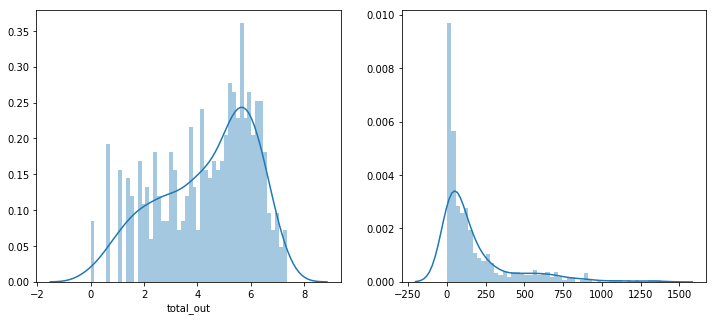

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_test,ax=ax1,bins=50)
sns.distplot(np.exp(test_pred),ax=ax2,bins=50)

#### PREDICTIONS NOT INCLUDING THE STATIONS 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(drop_features, axis = 1),
                                                    np.log1p(train_df['total_out']), test_size = 0.10, random_state = 42)

def two_score(y_true, y_pred):    
    #log_rmse = np.sqrt(mean_squared_log_error(np.exp(y_pred), np.exp(y_true))) #set score here and not below if using MSE in GridCV
    r2 = r2_score(np.exp(y_pred), np.exp(y_true))
    return r2

def two_scorer():
    return make_scorer(two_score, greater_is_better = True) # change to true if predicting r2

model_testing = 'random_forest'

# model tuning
if model_testing == 'ada_boost':
    parameters = {'n_estimators': list(range(50,700, 50)),
                  'learning_rate':[.001,0.01,.1],
                  'random_state':[1]}

    model = AdaBoostRegressor()
    
elif model_testing == 'random_forest':
    parameters = {'n_estimators': list(range(50,700, 50)),
                  'max_depth' : [2,4,8,10],
                  'bootstrap': [True],
                  'random_state':[1]
            }
    model = RandomForestRegressor()
    
elif model_testing == 'gradient_boosting':
    #parameters = 
    model =  GradientBoostingRegressor()
    
elif model_testing == 'bagging':
    model = BaggingRegressor()


search = GridSearchCV(estimator = model, param_grid = parameters, 
                      scoring = two_scorer(), n_jobs = 1)

search.fit(X_train, y_train)


In [ ]:
print(search.best_score_)
print(search.best_params_)

In [ ]:
print(grid.grid_scores_)